训练自编码器

1. 用含噪声的数据训练
2. 再降噪自编码器的输出的基础上进行重构

---

训练结果：



In [1]:
# 直接训练
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
import os

from torch.utils.tensorboard import SummaryWriter

from model.PIAE_models import T7PIAE5,T7DAE2,Vehicle_Model_Methods

# 检查是否有可用的GPU
if torch.cuda.is_available():
    print('显卡参与训练')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练开始前启用 PyTorch 的异常检测
torch.autograd.set_detect_anomaly(True)

显卡参与训练


In [2]:
# 加载数据
# 1. 加载预处理后的数据
##

def load_preprocessed_data(input_file):
    with open(input_file, 'rb') as f:
        data = pickle.load(f)
    return data

input_file = '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/data/Task2_data'  # 替换为你保存的.pkl文件路径
# 标准真值轨迹，标准噪声轨迹，标准化参数， 真值轨迹初值，噪声轨迹初值
tarin_data = load_preprocessed_data(os.path.join(input_file,'train_noisy_data.kpl'))

dataset = TensorDataset(tarin_data[0],tarin_data[1],tarin_data[3])
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)


val_data = load_preprocessed_data(os.path.join(input_file,'val_noisy_data.kpl'))

val_label = val_data[0].to(device)
val_input = val_data[1].to(device)
val_edge = val_data[3].to(device)


In [3]:

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self,outputs, targets, actions):

        mse_loss = nn.MSELoss()(outputs, targets)

        # 平滑loss
        ax = actions[:, :, 0]
        delta = actions[:, :, 1]

        loss_ax = torch.mean(torch.abs(torch.diff(ax,dim=1)))
        loss_delta = torch.mean(torch.abs(torch.diff(delta,dim=1)))*10
    
        return mse_loss + 1e-3*(loss_ax+loss_delta)

In [4]:

# 3. 定义模型、损失函数和优化器
#模型
model = T7PIAE5(torch.tensor(10),torch.tensor(0.25))
model.load_state_dict(torch.load('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/model/good_models/20250320_Task5-1_T7PIAE5.pth', weights_only=True))
model.to(device)


# DAE模型
dae_model = T7DAE2()
dae_model.load_state_dict(torch.load('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/model/good_models/20250323_Task7-1_T7DAE2.pth', weights_only=True))
dae_model.to(device)


# 损失函数
criterion = nn.MSELoss()
criterion_train = CustomLoss()

# 优化器
optimizer = optim.Adam([
    {'params': model.parameters(), 'lr': 1e-3}, # 5.0e-4 
    {'params': dae_model.parameters(), 'lr': 1e-3} # 5.0e-6
    ]) # lr=0.001



In [ ]:
%clear

# 创建一个SummaryWriter对象，指定日志保存的路径
writer = SummaryWriter('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/logs/log11')


# 4. 训练模型Autoencoder
epochs = 600

best_loss = float('inf')

for epoch in range(epochs):
    
    model.train()  # 确保模型处于训练模式
    for batch_idx, (label,input,edge) in enumerate(dataloader):  
        # 添加噪声
        
        label = label.to(device)  # 将输入数据移动到同一设备
        input = input.to(device)

        # with torch.no_grad():
        dae_out = dae_model(input)

        dae_loss = nn.MSELoss()(dae_out,label)

        feat = torch.diff(dae_out,dim=1)

        # # 真值边界
        # edagepoint = edge[:,0:2,:]
        # endstate = edge[:,2,:]

        # 重构的
        edagepoint = torch.stack([dae_out[:,0,:],dae_out[:,-1,:]],dim=1)
        ve = torch.sqrt((dae_out[:,-1,1]-dae_out[:,-2,1])**2 +(dae_out[:,-1,0]-dae_out[:,-2,0])**2)/torch.tensor(0.1)
        phie = torch.arctan2(dae_out[:,-1,1]-dae_out[:,-2,1],dae_out[:,-1,0]-dae_out[:,-2,0])
        endstate = torch.stack([ve,phie],dim=1)

        optimizer.zero_grad()
        outputs,actions = model(feat,edagepoint,endstate)

        loss = criterion_train(outputs, label,actions)
        # loss = criterion(outputs, dae_out)
        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        val_dae_out = dae_model(val_input)
        val_feat = torch.diff(val_dae_out,dim=1)

        # # 真值的
        # val_edagepoint = val_edge[:,0:2,:]
        # val_endstate = val_edge[:,2,:]
        # 重构的
        val_edagepoint = torch.stack([val_dae_out[:,0,:],val_dae_out[:,-1,:]],dim=1)
        val_ve = torch.sqrt((val_dae_out[:,-1,1]-val_dae_out[:,-2,1])**2 +(val_dae_out[:,-1,0]-val_dae_out[:,-2,0])**2)/torch.tensor(0.1)
        val_phie = torch.arctan2(val_dae_out[:,-1,1]-val_dae_out[:,-2,1],val_dae_out[:,-1,0]-val_dae_out[:,-2,0])
        val_endstate = torch.stack([val_ve,val_phie],dim=1)


        val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
        val_loss = criterion(val_output,val_label)
        orig_err = criterion(val_input, val_label)
        val_dae_loss = criterion(val_dae_out,val_label)

    print(f'验证集上的指标为:{val_loss}，总噪声为:{orig_err},减少噪声{orig_err-val_loss},dae上的噪声{val_dae_loss}')
    
    # torch.save(model.state_dict(), f'/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test6_piae_good/model/Task8_trained_model/model_{epoch:03}.pth')
    if val_loss.item() < best_loss :
        # 保存模型
        torch.save(model.state_dict(), '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/model/trained_models/Task11_piae5_best.pth')
        torch.save(dae_model.state_dict(), '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/model/trained_models/Task11_dae2_best.pth')
        best_loss = val_loss.item()


    print(f'Epoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')
    # print()
    # 使用SummaryWriter记录数据
    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)


# 关闭SummaryWriter
writer.close()
   


In [5]:

model.load_state_dict(torch.load('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/model/trained_models/Task11_piae5_best.pth', weights_only=True))
dae_model.load_state_dict(torch.load('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/model/trained_models/Task11_dae2_best.pth', weights_only=True))

model.eval()
with torch.no_grad():
    val_dae_out = dae_model(val_input)
    val_feat = torch.diff(val_dae_out,dim=1)

    # # 真值的
    # val_edagepoint = val_edge[:,0:2,:]
    # val_endstate = val_edge[:,2,:]
    
    # 重构的
    val_edagepoint = torch.stack([val_dae_out[:,0,:],val_dae_out[:,-1,:]],dim=1)
    val_ve = torch.sqrt((val_dae_out[:,-1,1]-val_dae_out[:,-2,1])**2 +(val_dae_out[:,-1,0]-val_dae_out[:,-2,0])**2)/torch.tensor(0.1)
    val_phie = torch.arctan2(val_dae_out[:,-1,1]-val_dae_out[:,-2,1],val_dae_out[:,-1,0]-val_dae_out[:,-2,0])
    val_endstate = torch.stack([val_ve,val_phie],dim=1)

    val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
    val_loss = criterion(val_output,val_label)
    orig_err = criterion(val_input, val_label)

print(f'验证集上的指标为:{val_loss}，总噪声为:{orig_err},减少噪声{orig_err-val_loss}')


验证集上的指标为:0.004949885420501232，总噪声为:0.025070490315556526,减少噪声0.02012060582637787


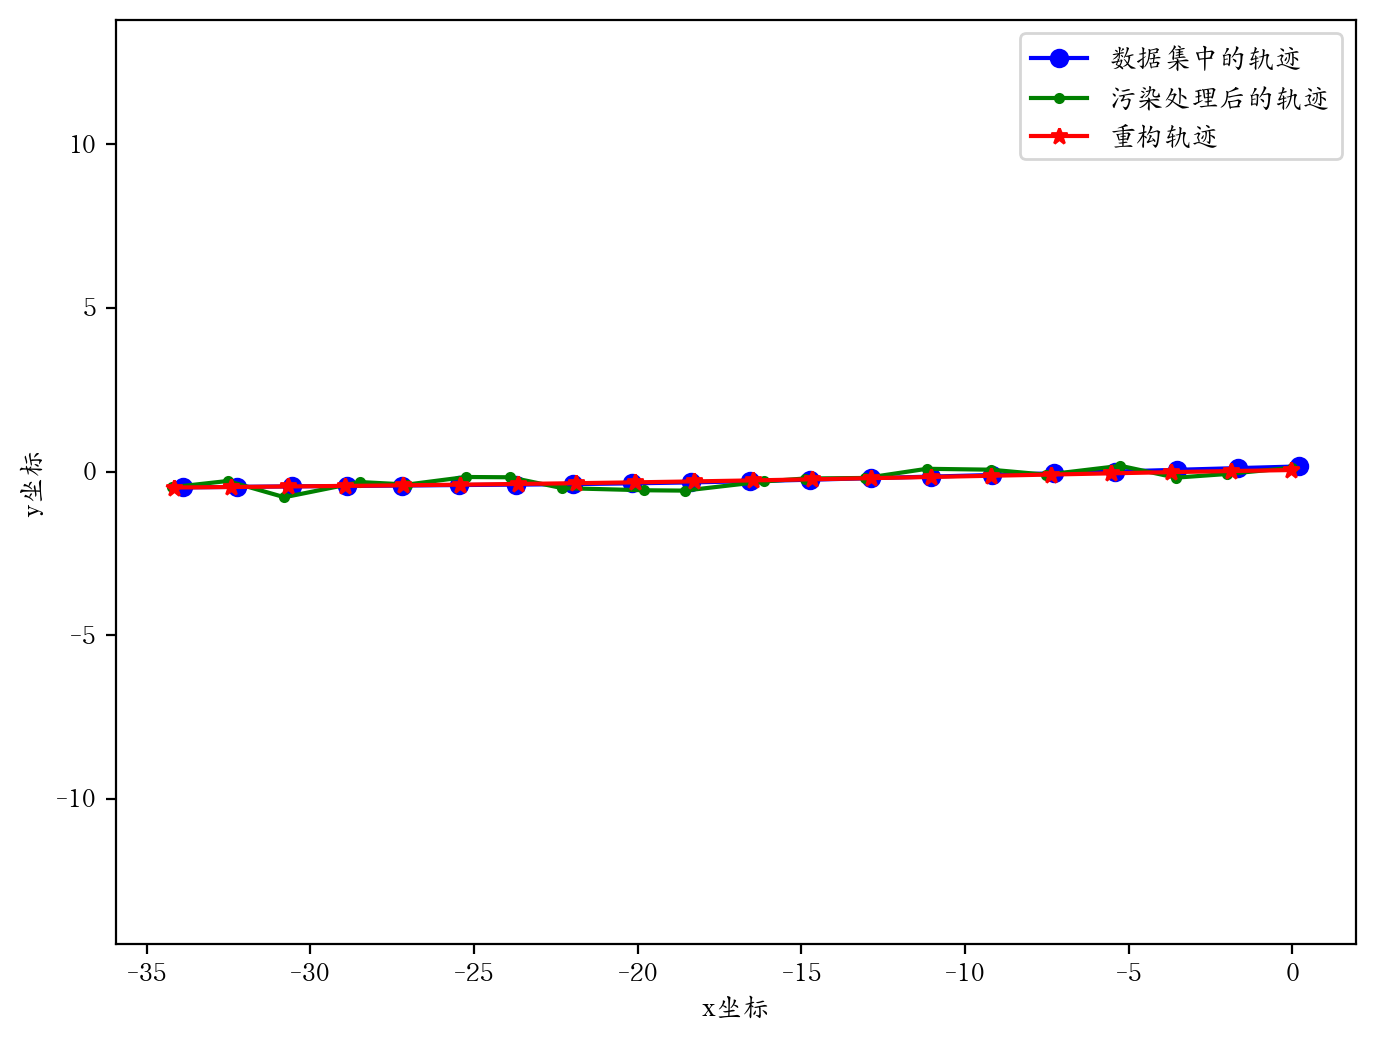

In [6]:
plt.figure(figsize=(8, 6),dpi=200)
plt.rcParams['font.sans-serif'] = ['AR PL UKai CN']  # 指定字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
# 绘制原始轨迹
import numpy as np
# num = 845
num = np.random.randint(0,30000)
# num = 3122
plt.plot(val_label.cpu().numpy()[num, :,0], val_label.cpu().numpy()[num, :,1], '-o',c='blue', label='数据集中的轨迹')
plt.plot(val_input.cpu().numpy()[num, :,0], val_input.cpu().numpy()[num, :,1], '.-',c='g', label='污染处理后的轨迹')
# plt.plot(val_dae_out.cpu().numpy()[num, :,0], val_dae_out.cpu().numpy()[num, :,1], '.-',c='c', label='DAE')
plt.plot(val_output.cpu().numpy()[num, :,0], val_output.cpu().numpy()[num, :,1], '*-', c='red', label='重构轨迹')
# plt.title('Reconstructed Trajectory')
plt.xlabel('x坐标')
plt.ylabel('y坐标')
plt.legend()
plt.axis('equal')
plt.savefig('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/plot_figs/fig_zl/fig10b.png')
plt.show()

In [7]:
# 定义专门用来重构轨迹的类, 计算误差ADE

class Reconstruct_Traj(Vehicle_Model_Methods):

    def __init__(self):
        super(Reconstruct_Traj, self).__init__()

    def ADE_err(self,out,label):
        ade = ((out - label) ** 2).sum(dim=2).sqrt().mean()
        return ade
    
    def calculate(self,actions,edagepoint,endstate,mode,labels):

        ax = actions[:,:,0]
        delta = actions[:,:,1]

        if mode == 'init_one':
            out = self.initial_unidirectional_reconstruct(ax,delta,edagepoint,endstate)
        elif mode == 'init_two':
            out = self.initial_bidirectional_reconstruct(ax,delta,edagepoint,endstate)
        elif mode == 'two_point':
            out,condtion = self.two_point_reconstruct(ax, delta, edagepoint, endstate)
        else:
            print(f'没有重构模式{mode}')
            out = torch.zeros(labels.shape, dtype=torch.float32, device=labels.device)
        
        loss_err = self.ADE_err(out,labels)

        loss_err = loss_err.cpu().numpy()

        return out,loss_err

In [8]:
recon_tarj = Reconstruct_Traj()

out_one, err_init_one = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'init_one',val_label)
print('单点单向重构误差',err_init_one)

out_two,err_init_two = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'init_two',val_label)
print('单点双向重构误差',err_init_two)

# out_2pt,err_two_point = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'two_point',val_label)
# print('单点单向重构误差',err_two_point)

单点单向重构误差 0.82548875
单点双向重构误差 0.07989106


3122


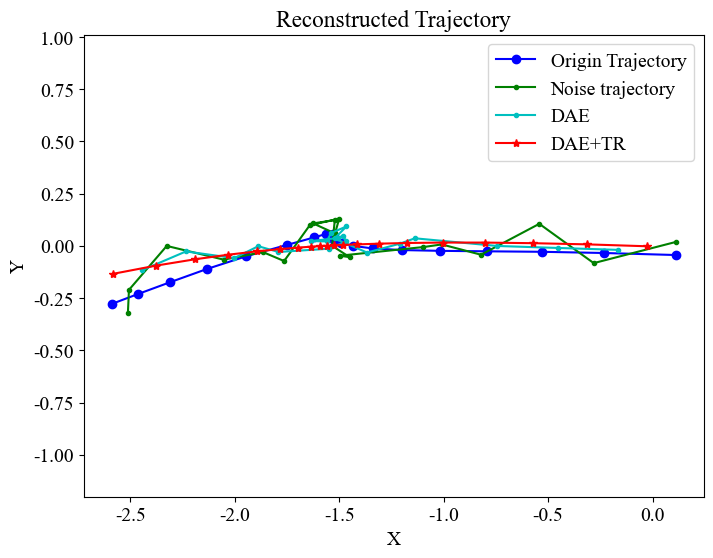

In [ ]:
plt.figure(figsize=(8, 6))

num = np.random.randint(30000)
num = 3122
print(num)
from matplotlib.font_manager import FontProperties


# 全局设置字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ["Times New Roman"]  # 使用字体路径
plt.rcParams['font.size'] = 14  # 设置全局字体大小


plt.plot(val_label.cpu().numpy()[num, :,0], val_label.cpu().numpy()[num, :,1], '-o',alpha=1, c='blue', label='Origin Trajectory')
plt.plot(val_input.cpu().numpy()[num, :,0], val_input.cpu().numpy()[num, :,1], '.-',alpha=1, c='g', label='Noise trajectory')
plt.plot(out_one.cpu().numpy()[num, :,0], out_one.cpu().numpy()[num, :,1], '*-', alpha=1, c='yellow', label='Reconstructed init one')
plt.plot(out_two.cpu().numpy()[num, :,0], out_two.cpu().numpy()[num, :,1], '*-', alpha=1, c='red', label='Reconstructed init two')
# plt.plot(out_2pt.cpu().numpy()[num, :,0], out_2pt.cpu().numpy()[num, :,1], '*-',alpha=1, c='k', label='Reconstructed two point')
plt.title('Reconstructed Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.show()